In [1]:
!cd "/content/drive/MyDrive/Colab Notebooks"

In [32]:
import pandas as pd
import numpy as np
from subprocess import check_call

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image as PImage
from PIL import Image, ImageDraw, ImageFont

In [3]:
train_data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/titanic_train.csv")
test_data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/titanic_test.csv")

In [4]:
test_data.drop(["PassengerId", "Ticket", "Name"], axis=1, inplace=True)

test_data.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,3,male,34.5,0,0,7.8292,NaN,Q
1,3,female,47.0,1,0,7.0000,NaN,S
2,2,male,62.0,0,0,9.6875,NaN,Q
3,3,male,27.0,0,0,8.6625,NaN,S
4,3,female,22.0,1,1,12.2875,NaN,S


In [5]:
train_data.drop(["PassengerId", "Ticket", "Name"], axis=1, inplace=True)

train_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,7.2500,NaN,S
1,1,1,female,38.0,1,0,71.2833,C85,C
2,1,3,female,26.0,0,0,7.9250,NaN,S
3,1,1,female,35.0,1,0,53.1000,C123,S
4,0,3,male,35.0,0,0,8.0500,NaN,S


In [6]:
train_data["Sex"] = train_data["Sex"].map({"male":1, "female":0})
train_data

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,1,22.0,1,0,7.2500,NaN,S
1,1,1,0,38.0,1,0,71.2833,C85,C
2,1,3,0,26.0,0,0,7.9250,NaN,S
3,1,1,0,35.0,1,0,53.1000,C123,S
4,0,3,1,35.0,0,0,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...
886,0,2,1,27.0,0,0,13.0000,NaN,S
887,1,1,0,19.0,0,0,30.0000,B42,S
888,0,3,0,NaN,1,2,23.4500,NaN,S
889,1,1,1,26.0,0,0,30.0000,C148,C


In [7]:
train_data.isna().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [8]:
train_data["Embarked"].fillna('S', inplace=True)

train_data.isna().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Cabin       687
Embarked      0
dtype: int64

In [9]:
md = train_data["Age"].median()
mo = train_data["Age"].mode()
max = train_data["Age"].max()

a = int((max-mo)/2)
b = int((max+mo)/2)
print(a,b)

28 52


In [10]:
import random
ls = []
for i in range(177):
  ls.append(random.randint(a,b))

print(len(ls))

177


In [11]:
train_data.loc[np.isnan(train_data['Age']), 'Age'] = ls
train_data['Age'] = train_data['Age'].astype(int)

In [12]:
train_data["Has_Cabin"] = train_data["Cabin"].apply(lambda x: 0 if type(x)==float else 1)
train_data.drop(["Cabin"], axis=1, inplace=True)
train_data

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Has_Cabin
0,0,3,1,22,1,0,7.2500,S,0
1,1,1,0,38,1,0,71.2833,C,1
2,1,3,0,26,0,0,7.9250,S,0
3,1,1,0,35,1,0,53.1000,S,1
4,0,3,1,35,0,0,8.0500,S,0
...,...,...,...,...,...,...,...,...,...
886,0,2,1,27,0,0,13.0000,S,0
887,1,1,0,19,0,0,30.0000,S,1
888,0,3,0,38,1,2,23.4500,S,0
889,1,1,1,26,0,0,30.0000,C,1


In [13]:
embarks = pd.get_dummies(train_data["Embarked"], prefix="Embarked", drop_first=True)
data = pd.concat([train_data, embarks], axis=1)

data

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Has_Cabin,Embarked_Q,Embarked_S
0,0,3,1,22,1,0,7.2500,S,0,0,1
1,1,1,0,38,1,0,71.2833,C,1,0,0
2,1,3,0,26,0,0,7.9250,S,0,0,1
3,1,1,0,35,1,0,53.1000,S,1,0,1
4,0,3,1,35,0,0,8.0500,S,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,1,27,0,0,13.0000,S,0,0,1
887,1,1,0,19,0,0,30.0000,S,1,0,1
888,0,3,0,38,1,2,23.4500,S,0,0,1
889,1,1,1,26,0,0,30.0000,C,1,0,0


In [14]:
data.drop(["Embarked"], axis=1, inplace=True)

In [15]:
x = data.drop(["Survived"], axis=1)
y = data["Survived"]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=57)

In [28]:
cv = KFold(n_splits=10)
acc = []
depth_range = range(1, len(list(test_data)) + 1)

In [29]:
for depth in depth_range:
  fold_acc = []
  dt_clf = DecisionTreeClassifier(max_depth=depth)
  for train_fold, test_fold in cv.split(data):
    f_train = data.loc[train_fold]
    f_test = data.loc[test_fold]

    model = dt_clf.fit(X = f_train.drop(["Survived"], axis=1), y = f_train["Survived"])
    valid_acc = model.score(X = f_test.drop(["Survived"], axis=1), y = f_test["Survived"])

    fold_acc.append(valid_acc)
  avg = sum(fold_acc)/len(fold_acc)
  acc.append(avg)

t = pd.DataFrame({"Max Depth": depth_range, "Average Accuracy": acc})
t = t[["Max Depth", "Average Accuracy"]]
print(t.to_string(index=False))    

 Max Depth  Average Accuracy
         1          0.786729
         2          0.766654
         3          0.809201
         4          0.795830
         5          0.798027
         6          0.805918
         7          0.785705
         8          0.794669


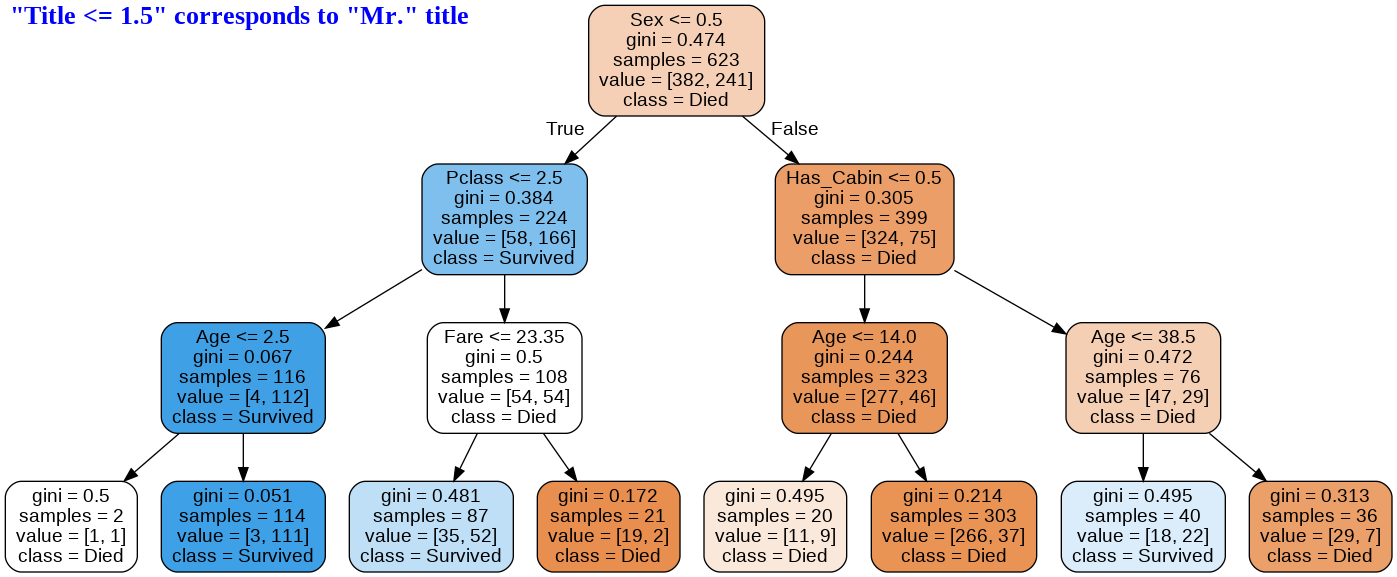

In [33]:
final_tree = DecisionTreeClassifier(max_depth=3)
final_tree.fit(x_train, y_train)

y_pred = final_tree.predict(x_test)

with open("tree1.dot", 'w') as f:
     f = tree.export_graphviz(final_tree,
                              out_file=f,
                              max_depth = 3,
                              impurity = True,
                              feature_names = list(data.drop(['Survived'], axis=1)),
                              class_names = ['Died', 'Survived'],
                              rounded = True,
                              filled= True )
        
#Convert .dot to .png to allow display in web notebook
check_call(['dot','-Tpng','tree1.dot','-o','tree1.png'])

# Annotating chart with PIL
img = Image.open("tree1.png")
draw = ImageDraw.Draw(img)
font = ImageFont.truetype('/usr/share/fonts/truetype/liberation/LiberationSerif-Bold.ttf', 26)
draw.text((10, 0), # Drawing offset (position)
          '"Title <= 1.5" corresponds to "Mr." title', # Text to draw
          (0,0,255), # RGB desired color
          font=font) # ImageFont object with desired font
img.save('sample-out.png')
PImage("sample-out.png")